In [1]:
import os
import pyart
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import xarray as xr
from datetime import datetime, timedelta

from metpy import plots, calc
from metpy.units import units
import profile_io as io

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

mpl.rcParams['xtick.labelsize'] = 6


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [13]:
# for each 100 second interval, plot the trajectory of the hailsonde ontop of a 4 panel figure of the nearest xsection in space and time.

output_folder = '/g/data/kl02/jss548/hail-research/hailsonde/nhp_output'

#config for dataset
dataset1_config = {'cut_down_s':315,'sondeid':'9931','timestamp':'2023-07-24_1631'}
dataset2_config = {'cut_down_s':255,'sondeid':'9935','timestamp':'2023-07-24_1636'}

#read dataset 1
timestamp1 = dataset1_config['timestamp']
sonde_id1 = dataset1_config['sondeid']
filename1 = f'/g/data/kl02/jss548/hail-research/hailsonde/20230724_hailsonde/{timestamp1}_{sonde_id1}.raw_flight_history.csv'
profile1, metadata1 = io.decode_raw_flight_history_nosplit(filename1, remove_nan_rows=True)

#read dataset 2
timestamp2 = dataset2_config['timestamp']
sonde_id2 = dataset2_config['sondeid']
filename2 = f'/g/data/kl02/jss548/hail-research/hailsonde/20230724_hailsonde/{timestamp2}_{sonde_id2}.raw_flight_history.csv'
profile2, metadata2 = io.decode_raw_flight_history_nosplit(filename2, remove_nan_rows=True)

gmt_offset = -6
profile1_start_dt = metadata1['launch_time'] #MUST BE UTC+0 TIME
profile2_start_dt = metadata2['launch_time'] #MUST BE UTC+0 TIME

#set
profile1_plot_t = 315+100 #cutdown time +100
profile2_plot_t = 255+100 #cutdown time +100

#load radars
# radar_site_alt = 810 #m
# radar_vols_path = '/g/data/kl02/jss548/hail-research/hailsonde/20230724_CASCV_subset'
# radars, radar_file_dt, radar_midpoint_dt_list = io.load_nhp_radar_data(radar_vols_path, 360)

radar_site_alt = 810 #m
radar_vols_path = '/g/data/kl02/jss548/hail-research/hailsonde/20230724_CASCV_subset_phido'
radars, radar_file_dt, radar_midpoint_dt_list = io.load_nhp_phido_radar_data(radar_vols_path, 360)



In [16]:
print(profile1_start_dt)
print(profile2_start_dt)

2023-07-24 22:35:09
2023-07-24 22:39:14


radar 1 sweep elevation: 1.6
radar 1 ffn: 2023-07-24 22:48:00
radar 1 sweep time: 2023-07-24 22:45:49
radar 2 sweep elevation: 1.6
radar 2 ffn: 2023-07-24 22:48:00
radar 2 sweep time: 2023-07-24 22:45:49
sonde1 time 2023-07-24 22:42:04
sonde1 alt 6772
sonde2 time 2023-07-24 22:45:09
sonde2 alt 6365


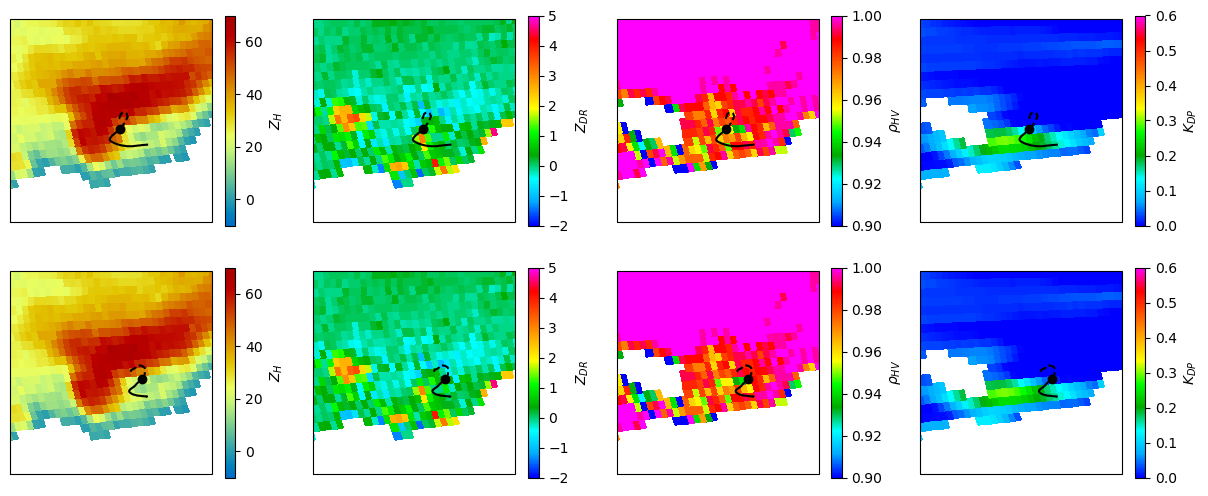

In [15]:
# plot DBZH, ZDR, RHOHV at the time of cutdown for each sonde

#profile 1
#set target time
target_dt1 = profile1_start_dt + timedelta(seconds = profile1_plot_t)
#find index in profile
idx1 = io.find_nearest_idx(profile1['time'], profile1_plot_t)
profile1_target_lat = profile1['lat'][idx1]
profile1_target_lon = profile1['lon'][idx1]
profile1_target_alt = profile1['hght']._magnitude[idx1]
#find nearest radar volume
profile1_radar_idx = io.find_nearest_dt_idx(target_dt1, radar_midpoint_dt_list)
#find nearest ppi sweep in volume
gate_lon = radars[profile1_radar_idx].gate_longitude['data']
gate_lat = radars[profile1_radar_idx].gate_latitude['data']
gate_alt = radars[profile1_radar_idx].gate_altitude['data'] + radar_site_alt
ray_time = radars[profile1_radar_idx].time['data']
ray_elevation = radars[profile1_radar_idx].elevation['data']
dist = np.sqrt((io.degrees2meters(gate_lat - profile1_target_lat))**2 + (io.degrees2meters(gate_lon - profile1_target_lon))**2 + (gate_alt - profile1_target_alt)**2)
min_dist_idx = np.unravel_index(np.abs(dist).argmin(), gate_lon.shape)
profile1_sweep_idx = io.find_nearest_idx(radars[profile1_radar_idx].fixed_angle['data'], ray_elevation[min_dist_idx[0]])
#calculate radar data point time
radar_sample_elv = int(ray_elevation[min_dist_idx[0]]*10)/10
radar_sample_alt = round(gate_alt[min_dist_idx])
radar1_sample_dt = datetime.strptime(radars[profile1_radar_idx].time['units'][14:], '%Y-%m-%dT%H:%M:%SZ') + timedelta(seconds=round(ray_time[min_dist_idx[0]]))
radar_vol_scan0_dt = datetime.strptime(radars[profile1_radar_idx].time['units'][14:], '%Y-%m-%dT%H:%M:%SZ')
radar1_vol_fn_dt = radar_file_dt[profile1_radar_idx]

#profile 2
#set target time
target_dt2 = profile2_start_dt + timedelta(seconds = profile2_plot_t)
#find index in profile
idx2 = io.find_nearest_idx(profile2['time'], profile2_plot_t)
profile2_target_lat = profile2['lat'][idx2]
profile2_target_lon = profile2['lon'][idx2]
profile2_target_alt = profile2['hght']._magnitude[idx2]
#find nearest radar volume
profile2_radar_idx = io.find_nearest_dt_idx(target_dt2, radar_midpoint_dt_list)
#find nearest ppi sweep in volume
gate_lon = radars[profile2_radar_idx].gate_longitude['data']
gate_lat = radars[profile2_radar_idx].gate_latitude['data']
gate_alt = radars[profile2_radar_idx].gate_altitude['data'] + radar_site_alt
ray_time = radars[profile2_radar_idx].time['data']
ray_elevation = radars[profile2_radar_idx].elevation['data']
dist = np.sqrt((io.degrees2meters(gate_lat - profile2_target_lat))**2 + (io.degrees2meters(gate_lon - profile2_target_lon))**2 + (gate_alt - profile2_target_alt)**2)
min_dist_idx = np.unravel_index(np.abs(dist).argmin(), gate_lon.shape)
profile2_sweep_idx = io.find_nearest_idx(radars[profile2_radar_idx].fixed_angle['data'], ray_elevation[min_dist_idx[0]])
#calculate radar data point time
radar_sample_elv = int(ray_elevation[min_dist_idx[0]]*10)/10
radar_sample_alt = round(gate_alt[min_dist_idx])
radar2_sample_dt = datetime.strptime(radars[profile2_radar_idx].time['units'][14:], '%Y-%m-%dT%H:%M:%SZ') + timedelta(seconds=round(ray_time[min_dist_idx[0]]))
radar_vol_scan0_dt = datetime.strptime(radars[profile2_radar_idx].time['units'][14:], '%Y-%m-%dT%H:%M:%SZ')
radar2_vol_fn_dt = radar_file_dt[profile2_radar_idx]

print('radar 1 sweep elevation:', radars[profile1_radar_idx].fixed_angle['data'][profile1_sweep_idx])
print('radar 1 ffn:', radar1_vol_fn_dt)
print('radar 1 sweep time:', radar1_sample_dt)
print('radar 2 sweep elevation:', radars[profile2_radar_idx].fixed_angle['data'][profile2_sweep_idx])
print('radar 2 ffn:', radar2_vol_fn_dt)
print('radar 2 sweep time:', radar2_sample_dt)

#plot
fig = plt.figure(figsize=(15, 6))
min_lon=-116.25
max_lon=-116.0
min_lat=53.3
max_lat=53.55
storm_u = 8.15
storm_v = 1.42

display1 = pyart.graph.RadarMapDisplay(radars[profile1_radar_idx])
ax1 = fig.add_subplot(241, projection=ccrs.PlateCarree())
display1.plot_ppi_map('DBZH', 
                        sweep=profile1_sweep_idx, ax=ax1, vmin=-10, vmax=70,
                        colorbar_label='$Z_{H}$', title_flag=False,
                        lon_lines=[],
                        lat_lines=[],
                        min_lon=min_lon,
                        max_lon=max_lon,
                        min_lat=min_lat,
                        max_lat=max_lat)
display1.plot_line_geo(profile1['lon'][:idx1], profile1['lat'][:idx1], 'k-')    
display1.plot_line_geo(profile1['lon'][idx1:], profile1['lat'][idx1:], 'k--')
display1.plot_point(profile1_target_lon, profile1_target_lat, symbol='ko')

ax2 = fig.add_subplot(242, projection=ccrs.PlateCarree())
display1.plot_ppi_map('ZDR', 
                        sweep=profile1_sweep_idx, ax=ax2, vmin=-2, vmax=5, cmap='pyart_RefDiff',
                        colorbar_label='$Z_{DR}$', title_flag=False, 
                        lon_lines=[],
                        lat_lines=[],
                        min_lon=min_lon,
                        max_lon=max_lon,
                        min_lat=min_lat,
                        max_lat=max_lat)
display1.plot_line_geo(profile1['lon'][:idx1], profile1['lat'][:idx1], 'k-')    
display1.plot_line_geo(profile1['lon'][idx1:], profile1['lat'][idx1:], 'k--')
display1.plot_point(profile1_target_lon, profile1_target_lat, symbol='ko')
ax2.tick_params(labelleft=False)  

ax3 = fig.add_subplot(243, projection=ccrs.PlateCarree())
display1.plot_ppi_map('RHOHV', 
                        sweep=profile1_sweep_idx, ax=ax3, vmin=0.9, vmax=1, cmap='pyart_RefDiff',
                        colorbar_label='$ρ_{HV}$', title_flag=False,
                        lon_lines=[],
                        lat_lines=[],
                        min_lon=min_lon,
                        max_lon=max_lon,
                        min_lat=min_lat,
                        max_lat=max_lat)
display1.plot_line_geo(profile1['lon'][:idx1], profile1['lat'][:idx1], 'k-')    
display1.plot_line_geo(profile1['lon'][idx1:], profile1['lat'][idx1:], 'k--')
display1.plot_point(profile1_target_lon, profile1_target_lat, symbol='ko')

ax3a = fig.add_subplot(244, projection=ccrs.PlateCarree())
display1.plot_ppi_map('KDP_PHIDO', 
                        sweep=profile1_sweep_idx, ax=ax3a, vmin=0, vmax=0.6, cmap='pyart_RefDiff',
                        colorbar_label='$K_{DP}$', title_flag=False,
                        lon_lines=[],
                        lat_lines=[],
                        min_lon=min_lon,
                        max_lon=max_lon,
                        min_lat=min_lat,
                        max_lat=max_lat)
display1.plot_line_geo(profile1['lon'][:idx1], profile1['lat'][:idx1], 'k-')    
display1.plot_line_geo(profile1['lon'][idx1:], profile1['lat'][idx1:], 'k--')
display1.plot_point(profile1_target_lon, profile1_target_lat, symbol='ko')


display2 = pyart.graph.RadarMapDisplay(radars[profile2_radar_idx])
ax4 = fig.add_subplot(245, projection=ccrs.PlateCarree())
display2.plot_ppi_map('DBZH', 
                        sweep=profile2_sweep_idx, ax=ax4, vmin=-10, vmax=70,
                        colorbar_label='$Z_{H}$', title_flag=False,
                        lon_lines=[],
                        lat_lines=[],
                        min_lon=min_lon,
                        max_lon=max_lon,
                        min_lat=min_lat,
                        max_lat=max_lat)
display2.plot_line_geo(profile2['lon'][:idx2], profile2['lat'][:idx2], 'k-')    
display2.plot_line_geo(profile2['lon'][idx2:], profile2['lat'][idx2:], 'k--')
display2.plot_point(profile2_target_lon, profile2_target_lat, symbol='ko')

ax5 = fig.add_subplot(246, projection=ccrs.PlateCarree())
display2.plot_ppi_map('ZDR', 
                        sweep=profile2_sweep_idx, ax=ax5, vmin=-2, vmax=5, cmap='pyart_RefDiff',
                        colorbar_label='$Z_{DR}$', title_flag=False,
                        lon_lines=[],
                        lat_lines=[],
                        min_lon=min_lon,
                        max_lon=max_lon,
                        min_lat=min_lat,
                        max_lat=max_lat)
display2.plot_line_geo(profile2['lon'][:idx2], profile2['lat'][:idx2], 'k-')    
display2.plot_line_geo(profile2['lon'][idx2:], profile2['lat'][idx2:], 'k--')
display2.plot_point(profile2_target_lon, profile2_target_lat, symbol='ko')

ax6 = fig.add_subplot(247, projection=ccrs.PlateCarree())
display2.plot_ppi_map('RHOHV', 
                        sweep=profile2_sweep_idx, ax=ax6, vmin=0.9, vmax=1, cmap='pyart_RefDiff',
                        colorbar_label='$ρ_{HV}$', title_flag=False,
                        lon_lines=[],
                        lat_lines=[],
                        min_lon=min_lon,
                        max_lon=max_lon,
                        min_lat=min_lat,
                        max_lat=max_lat)
display2.plot_line_geo(profile2['lon'][:idx2], profile2['lat'][:idx2], 'k-')    
display2.plot_line_geo(profile2['lon'][idx2:], profile2['lat'][idx2:], 'k--')
display2.plot_point(profile2_target_lon, profile2_target_lat, symbol='ko')

ax6a = fig.add_subplot(248, projection=ccrs.PlateCarree())
display2.plot_ppi_map('KDP_PHIDO', 
                        sweep=profile2_sweep_idx, ax=ax6a, vmin=0, vmax=0.6, cmap='pyart_RefDiff',
                        colorbar_label='$K_{DP}$', title_flag=False,
                        lon_lines=[],
                        lat_lines=[],
                        min_lon=min_lon,
                        max_lon=max_lon,
                        min_lat=min_lat,
                        max_lat=max_lat)
display2.plot_line_geo(profile2['lon'][:idx2], profile2['lat'][:idx2], 'k-')    
display2.plot_line_geo(profile2['lon'][idx2:], profile2['lat'][idx2:], 'k--')
display2.plot_point(profile2_target_lon, profile2_target_lat, symbol='ko')

#sonde stats
print('sonde1 time', target_dt1)
print('sonde1 alt', profile1_target_alt)

print('sonde2 time', target_dt2)
print('sonde2 alt', profile2_target_alt)

plt.savefig(f'{output_folder}/Publication_hailsonde_ppi.png')